# Vizualizace metody BeCoMe

Notebook demonstruje výsledky metody na třech datových sadách z oblasti veřejné politiky ČR.

## Obsah

1. [Načtení dat](#section-data)
2. [Trojúhelníkové funkce příslušnosti](#section-tfn)
3. [Graf centroidů](#section-centroid)
4. [Citlivostní analýza](#section-sensitivity)
5. [Srovnávací dashboard](#section-dashboard)
6. [Ukazatel přesnosti](#section-gauge)
7. [Závěr](#section-conclusion)

---

In [1]:
# Importy
import os
import sys
from pathlib import Path

import ipywidgets as widgets
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from matplotlib.gridspec import GridSpec

# Přidání kořenového adresáře projektu do Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.insert(0, project_root)

# Definice cest - česká verze dat
data_dir = Path(os.getcwd()) / ".." / ".." / "data" / "cs"
output_dir = Path(os.getcwd()) / "output"

from examples.utils.analysis import calculate_agreement_level
from examples.utils.data_loading import load_data_from_txt
from src.calculators.become_calculator import BeCoMeCalculator

# Nastavení grafů
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10

<a id="section-data"></a>

## 1. Načtení dat

Načítáme tři datové sady: rozpočet (22 expertů), povodně (13 expertů), pendleři (22 expertů).

In [2]:
# Případ rozpočtu
budget_opinions, budget_metadata = load_data_from_txt(str(data_dir / "budget_case.txt"))
budget_calculator = BeCoMeCalculator()
budget_result = budget_calculator.calculate_compromise(budget_opinions)

# Případ povodní
floods_opinions, floods_metadata = load_data_from_txt(str(data_dir / "floods_case.txt"))
floods_calculator = BeCoMeCalculator()
floods_result = floods_calculator.calculate_compromise(floods_opinions)

# Případ pendlerů
pendlers_opinions, pendlers_metadata = load_data_from_txt(str(data_dir / "pendlers_case.txt"))
pendlers_calculator = BeCoMeCalculator()
pendlers_result = pendlers_calculator.calculate_compromise(pendlers_opinions)

print("Data načtena:")
print(f"  Rozpočet: {len(budget_opinions)} expertů, δ_max = {budget_result.max_error:.2f}")
print(f"  Povodně: {len(floods_opinions)} expertů, δ_max = {floods_result.max_error:.2f}")
print(f"  Pendleři: {len(pendlers_opinions)} expertů, δ_max = {pendlers_result.max_error:.2f}")

Data načtena:
  Rozpočet: 22 expertů, δ_max = 2.20
  Povodně: 13 expertů, δ_max = 5.97
  Pendleři: 22 expertů, δ_max = 5.68


<a id="section-tfn"></a>

## 2. Trojúhelníkové funkce příslušnosti

Graf zobrazuje všechny expertní odhady jako trojúhelníky.
Barevné čáry označují agregační metody: Γ (průměr), Ω (medián), kompromis.

In [3]:
def plot_triangular_membership_functions(opinions, result, title, case_name, unit=""):
    """Vizualizace trojúhelníkových funkcí příslušnosti pro všechny experty."""
    _fig, ax = plt.subplots(figsize=(14, 7))

    expert_color = "lightblue"
    expert_alpha = 0.3
    mean_color = "#FF6B6B"
    median_color = "#4ECDC4"
    compromise_color = "#FFD93D"

    for opinion in opinions:
        lower = opinion.opinion.lower_bound
        peak = opinion.opinion.peak
        upper = opinion.opinion.upper_bound
        x = [lower, peak, upper, lower]
        y = [0, 1, 0, 0]
        ax.fill(x, y, color=expert_color, alpha=expert_alpha, edgecolor="gray", linewidth=0.5)

    def draw_aggregate_triangle(fuzzy_num, color, label, linewidth=3):
        x = [fuzzy_num.lower_bound, fuzzy_num.peak, fuzzy_num.upper_bound, fuzzy_num.lower_bound]
        y = [0, 1, 0, 0]
        ax.plot(x, y, color=color, linewidth=linewidth, label=label, zorder=5)
        ax.fill(x, y, color=color, alpha=0.15, zorder=4)

    mean_label = f"Γ (průměr)\nCentroid: {result.arithmetic_mean.centroid:.2f} {unit}".strip()
    median_label = f"Ω (medián)\nCentroid: {result.median.centroid:.2f} {unit}".strip()
    compromise_label = (
        f"ΓΩMean (kompromis)\nCentroid: {result.best_compromise.centroid:.2f} {unit}".strip()
    )

    draw_aggregate_triangle(result.arithmetic_mean, mean_color, mean_label)
    draw_aggregate_triangle(result.median, median_color, median_label)
    draw_aggregate_triangle(result.best_compromise, compromise_color, compromise_label)

    ax.set_xlabel("Hodnota", fontsize=12, fontweight="bold")
    ax.set_ylabel("Stupeň příslušnosti μ(x)", fontsize=12, fontweight="bold")
    ax.set_title(
        f"{title}\nTrojúhelníkové funkce příslušnosti ({len(opinions)} expertů)",
        fontsize=14,
        fontweight="bold",
    )
    ax.set_ylim(-0.05, 1.1)
    ax.legend(fontsize=11, loc="upper right")
    ax.grid(True, alpha=0.3)

    expert_patch = mpatches.Patch(
        facecolor=expert_color, alpha=expert_alpha, edgecolor="gray", label="Expertní odhady"
    )
    handles, labels = ax.get_legend_handles_labels()
    handles.insert(0, expert_patch)
    labels.insert(0, "Expertní odhady")
    ax.legend(handles, labels, fontsize=11, loc="upper right")

    plt.tight_layout()
    plt.savefig(output_dir / f"{case_name}_membership_functions.png", dpi=300, bbox_inches="tight")
    plt.show()

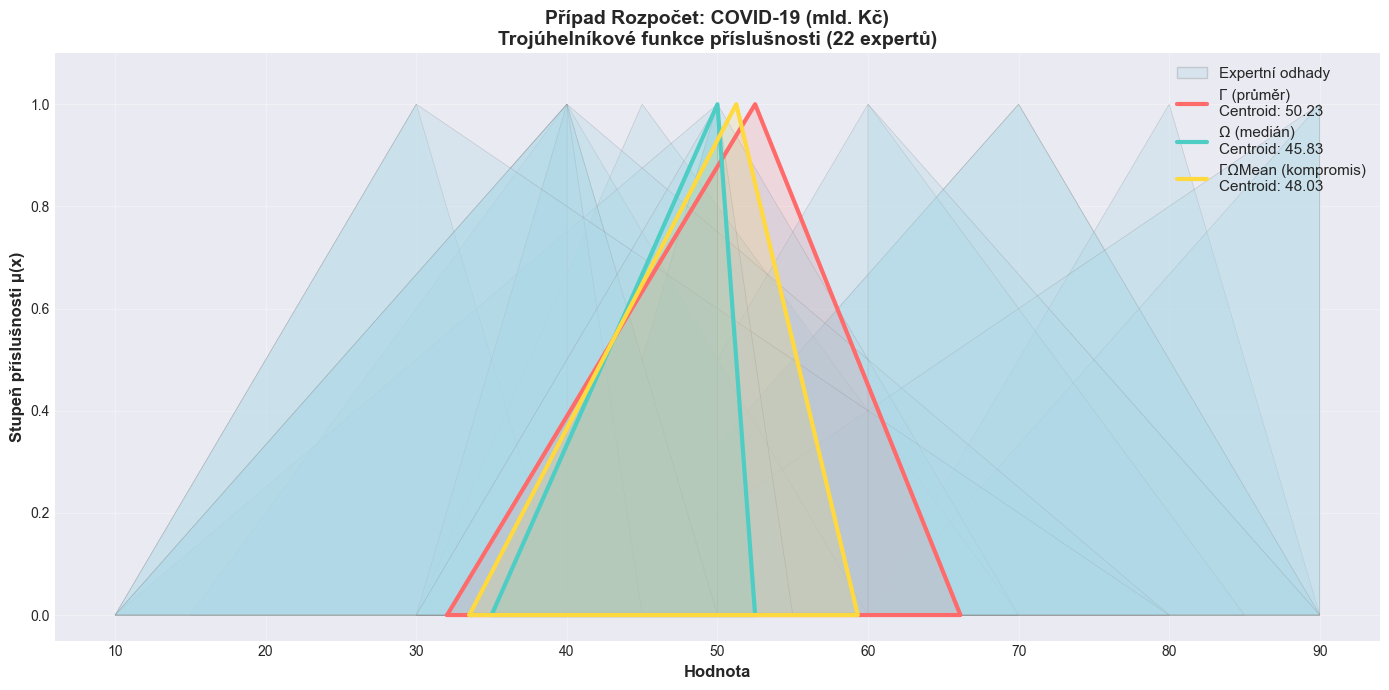

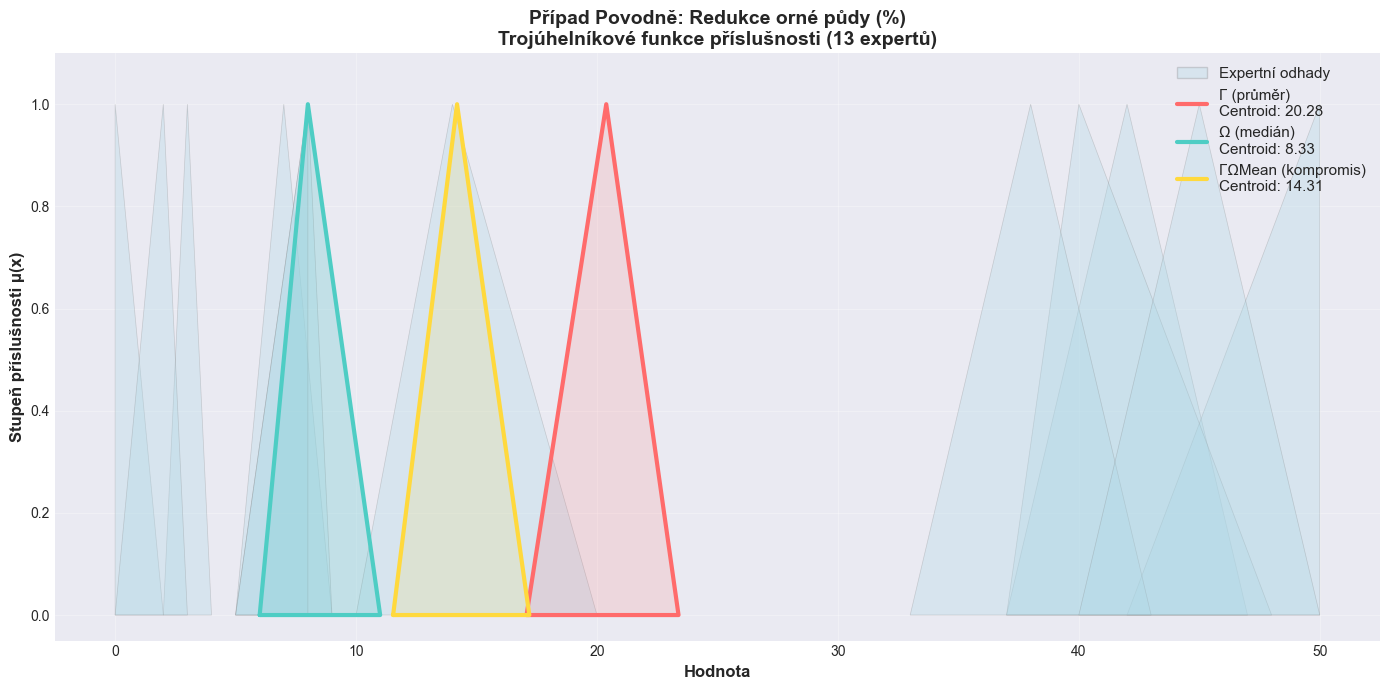

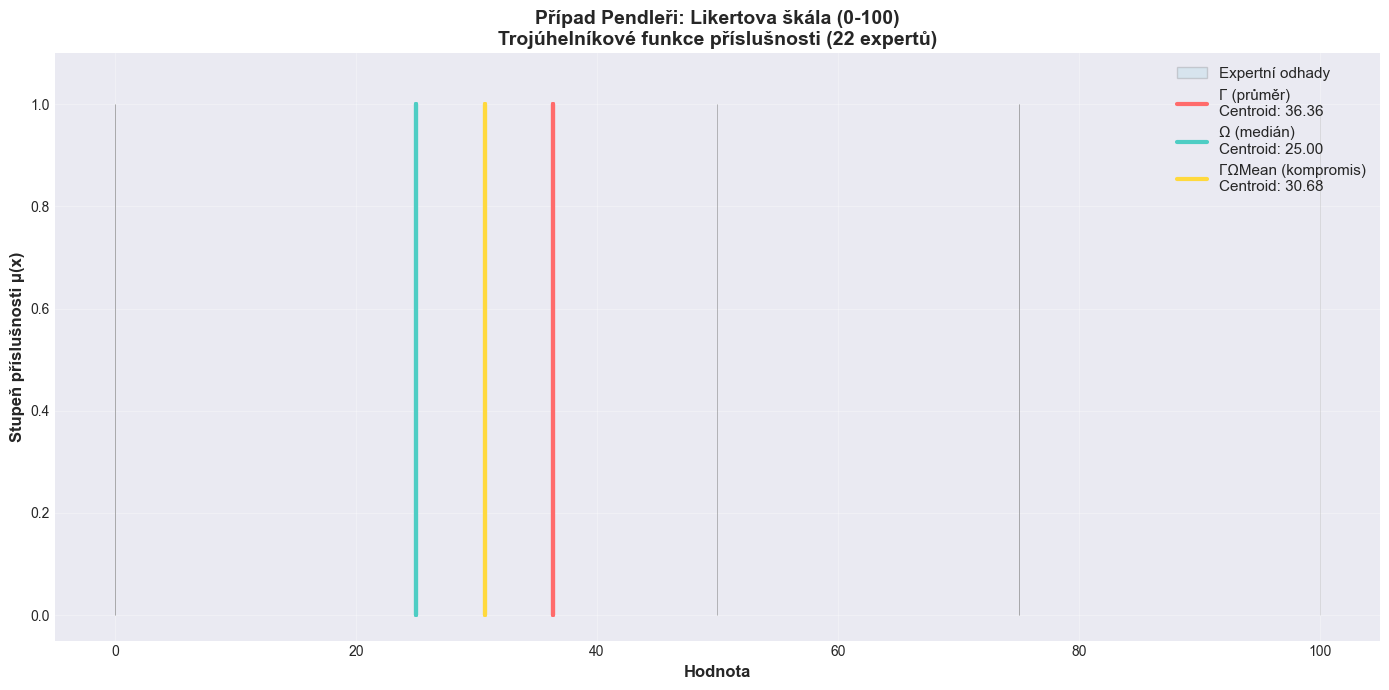

In [4]:
plot_triangular_membership_functions(
    budget_opinions, budget_result, "Případ Rozpočet: COVID-19 (mld. Kč)", "budget"
)
plot_triangular_membership_functions(
    floods_opinions, floods_result, "Případ Povodně: Redukce orné půdy (%)", "floods"
)
plot_triangular_membership_functions(
    pendlers_opinions, pendlers_result, "Případ Pendleři: Likertova škála (0-100)", "pendlers"
)

### Interpretace

**Budget:** Experti se shodují (δ_max = 2.20), odhady leží v rozmezí 45-60 mld. CZK. Všechny agregáty jsou blízko sebe.

**Floods:** Rozdělení je bimodální (δ_max = 5.97). Experti jsou rozděleni na dvě skupiny: konzervativní (0-10%) a radikální (25-40%).

**Pendlers:** Shoda je silná s jedním outlierem (δ_max = 5.68). Většina expertů se nachází v úzkém pásmu 24-26.

<a id="section-centroid"></a>

## 3. Graf centroidů

Centroid představuje těžiště trojúhelníku. Experti jsou seřazeni od nejnižšího k nejvyššímu centroidu.
Vzdálenost mezi čarami Γ a Ω určuje hodnotu δ_max.

In [5]:
def plot_centroid_chart(opinions, result, title, case_name):
    """Graf centroidů expertů s vyznačenými agregovanými hodnotami."""
    sorted_opinions = sorted(opinions, key=lambda op: op.centroid)
    expert_ids = [op.expert_id for op in sorted_opinions]
    centroids = [op.centroid for op in sorted_opinions]
    df = pd.DataFrame({"expert_id": expert_ids, "centroid": centroids})

    _fig, ax = plt.subplots(figsize=(14, 7))

    ax.bar(
        range(len(df)),
        df["centroid"],
        color="steelblue",
        alpha=0.7,
        edgecolor="black",
        linewidth=0.5,
    )

    mean_centroid = result.arithmetic_mean.centroid
    median_centroid = result.median.centroid
    compromise_centroid = result.best_compromise.centroid

    ax.axhline(
        y=mean_centroid,
        color="#FF6B6B",
        linestyle="--",
        linewidth=2.5,
        label=f"Γ (průměr): {mean_centroid:.2f}",
        zorder=5,
    )
    ax.axhline(
        y=median_centroid,
        color="#4ECDC4",
        linestyle="--",
        linewidth=2.5,
        label=f"Ω (medián): {median_centroid:.2f}",
        zorder=5,
    )
    ax.axhline(
        y=compromise_centroid,
        color="#FFD93D",
        linestyle="--",
        linewidth=2.5,
        label=f"ΓΩMean: {compromise_centroid:.2f}",
        zorder=5,
    )
    ax.plot([], [], " ", label=f"δ_max = {result.max_error:.2f}")

    ax.set_xlabel("Experti (seřazeni podle centroidu)", fontsize=12, fontweight="bold")
    ax.set_ylabel("Hodnota centroidu", fontsize=12, fontweight="bold")
    ax.set_title(f"{title}\nCentroidy expertů a agregované hodnoty", fontsize=14, fontweight="bold")
    ax.set_xticks(range(len(df)))
    ax.set_xticklabels(df["expert_id"], rotation=45, ha="right")
    ax.legend(fontsize=11, loc="upper left")
    ax.grid(True, alpha=0.3, axis="y")

    plt.tight_layout()
    plt.savefig(output_dir / f"{case_name}_centroids.png", dpi=300, bbox_inches="tight")
    plt.show()

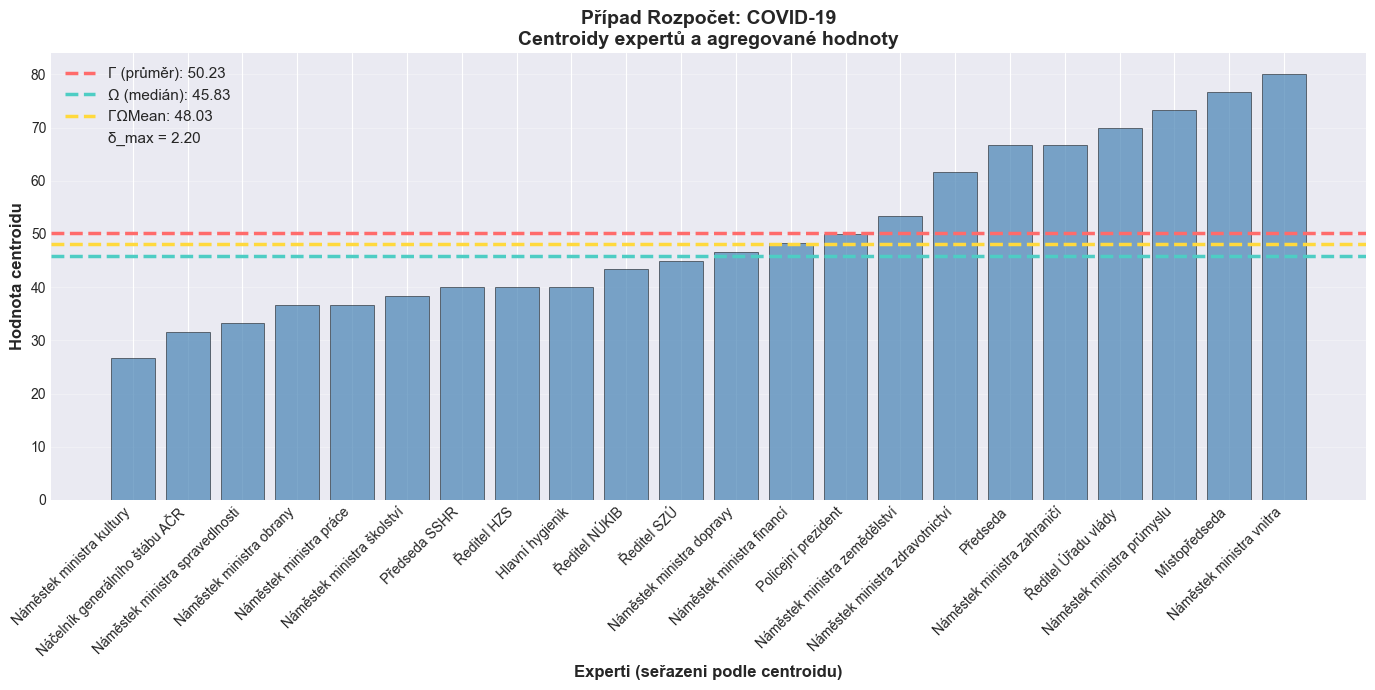

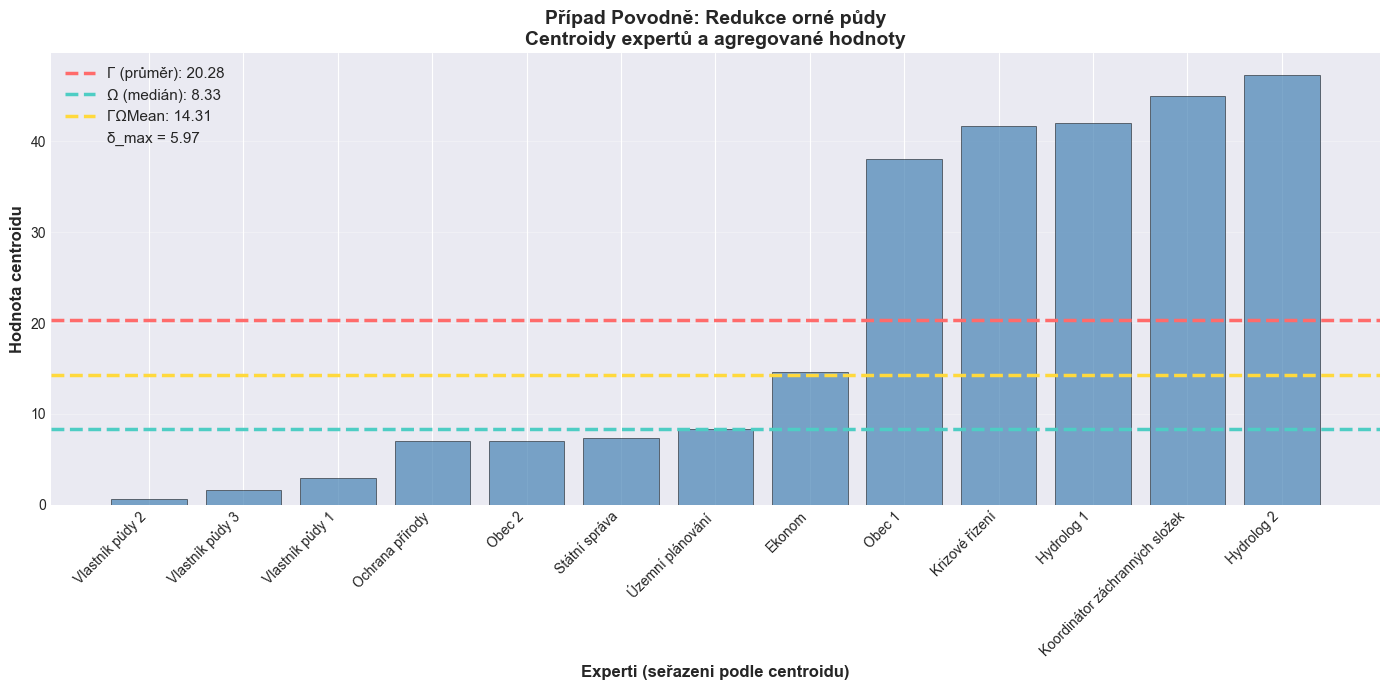

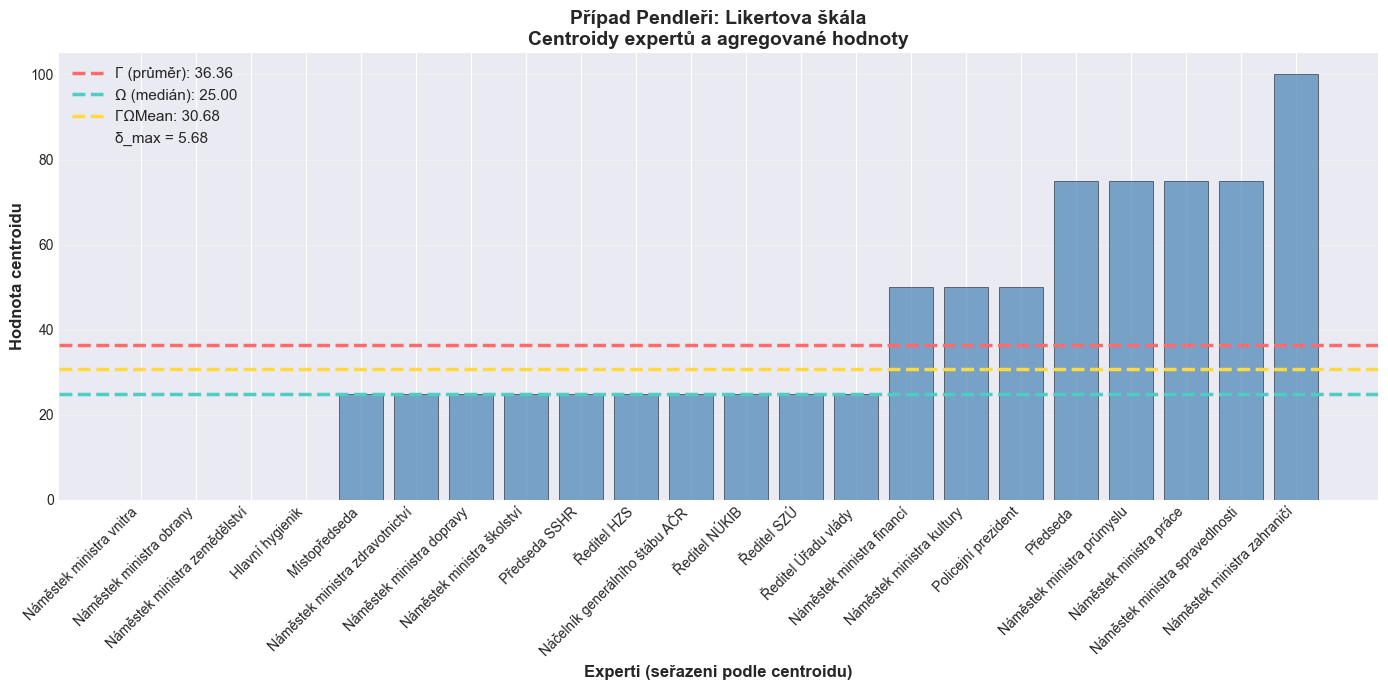

In [6]:
plot_centroid_chart(budget_opinions, budget_result, "Případ Rozpočet: COVID-19", "budget")
plot_centroid_chart(floods_opinions, floods_result, "Případ Povodně: Redukce orné půdy", "floods")
plot_centroid_chart(
    pendlers_opinions, pendlers_result, "Případ Pendleři: Likertova škála", "pendlers"
)

### Interpretace

**Budget:** Centroidy plynule rostou od 26 do 80 mld. CZK. Čáry Γ, Ω a ΓΩMean jsou velmi blízko.

**Floods:** Vznikají dva shluky: nízké hodnoty (0-15%) a vysoké (25-45%). Vzdálenost mezi Γ a Ω je velká.

**Pendlers:** Většina centroidů se nachází v úzkém pásmu 24-28. Expert A22 je výrazně odlehlý (centroid ~44).

<a id="section-sensitivity"></a>

## 4. Citlivostní analýza

Tento nástroj slouží k interaktivnímu testování vlivu jednotlivých expertů na výsledek.
Vyloučením experta lze sledovat změnu hodnoty δ_max.

In [7]:
def create_sensitivity_analysis_widget(opinions, title, case_name):
    """Interaktivní widget pro analýzu citlivosti."""
    checkboxes = {}
    for op in opinions:
        checkboxes[op.expert_id] = widgets.Checkbox(
            value=True,
            description=f"{op.expert_id} (c={op.centroid:.1f})",
            style={"description_width": "initial"},
            layout=widgets.Layout(width="350px"),
        )

    output = widgets.Output()

    def update_plot(change=None):
        selected_opinions = [op for op in opinions if checkboxes[op.expert_id].value]

        if len(selected_opinions) < 2:
            with output:
                output.clear_output(wait=True)
                print("VAROVÁNÍ: Vyberte alespoň 2 experty pro výpočet")
            return

        calculator = BeCoMeCalculator()
        result = calculator.calculate_compromise(selected_opinions)

        with output:
            output.clear_output(wait=True)
            _fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

            expert_color = "lightblue"
            for op in selected_opinions:
                x = [
                    op.opinion.lower_bound,
                    op.opinion.peak,
                    op.opinion.upper_bound,
                    op.opinion.lower_bound,
                ]
                y = [0, 1, 0, 0]
                ax1.fill(x, y, color=expert_color, alpha=0.3, edgecolor="gray", linewidth=0.5)

            for fuzzy_num, color, base_label in [
                (result.arithmetic_mean, "#FF6B6B", "Průměr"),
                (result.median, "#4ECDC4", "Medián"),
                (result.best_compromise, "#FFD93D", "Kompromis"),
            ]:
                x = [
                    fuzzy_num.lower_bound,
                    fuzzy_num.peak,
                    fuzzy_num.upper_bound,
                    fuzzy_num.lower_bound,
                ]
                y = [0, 1, 0, 0]
                label_with_value = f"{base_label}: [{fuzzy_num.lower_bound:.2f}, {fuzzy_num.peak:.2f}, {fuzzy_num.upper_bound:.2f}]"
                ax1.plot(x, y, color=color, linewidth=2.5, label=label_with_value)

            ax1.set_xlabel("Hodnota", fontweight="bold")
            ax1.set_ylabel("μ(x)", fontweight="bold")
            ax1.set_title(
                f"Funkce příslušnosti ({len(selected_opinions)} expertů)", fontweight="bold"
            )
            ax1.legend(loc="upper left")
            ax1.grid(True, alpha=0.3)
            ax1.set_ylim(-0.05, 1.1)

            sorted_ops = sorted(selected_opinions, key=lambda x: x.centroid)
            centroids = [op.centroid for op in sorted_ops]
            expert_ids = [op.expert_id for op in sorted_ops]

            ax2.bar(range(len(centroids)), centroids, color="steelblue", alpha=0.7)
            ax2.axhline(
                y=result.arithmetic_mean.centroid,
                color="#FF6B6B",
                linestyle="--",
                linewidth=2,
                label=f"Průměr: {result.arithmetic_mean.centroid:.2f}",
            )
            ax2.axhline(
                y=result.median.centroid,
                color="#4ECDC4",
                linestyle="--",
                linewidth=2,
                label=f"Medián: {result.median.centroid:.2f}",
            )
            ax2.axhline(
                y=result.best_compromise.centroid,
                color="#FFD93D",
                linestyle="--",
                linewidth=2,
                label=f"Kompromis: {result.best_compromise.centroid:.2f}",
            )

            ax2.set_xlabel("Experti", fontweight="bold")
            ax2.set_ylabel("Centroid", fontweight="bold")
            ax2.set_title(f"Centroidy (δ_max = {result.max_error:.2f})", fontweight="bold")
            ax2.set_xticks(range(len(expert_ids)))
            ax2.set_xticklabels(expert_ids, rotation=45, ha="right")
            ax2.legend()
            ax2.grid(True, alpha=0.3, axis="y")

            plt.tight_layout()
            plt.show()

    for checkbox in checkboxes.values():
        checkbox.observe(update_plot, names="value")

    update_plot()

    checkbox_cols = []
    items_per_col = 8
    checkbox_list = list(checkboxes.values())
    for i in range(0, len(checkbox_list), items_per_col):
        checkbox_cols.append(widgets.VBox(checkbox_list[i : i + items_per_col]))

    controls = widgets.HBox(checkbox_cols)
    title_widget = widgets.HTML(f"<h3>{title} - Citlivostní analýza</h3>")
    info_widget = widgets.HTML(
        "<p><i>Vyberte/odškrtněte experty pro zobrazení vlivu na výsledek BeCoMe</i></p>"
    )
    display(widgets.VBox([title_widget, info_widget, controls, output]))

In [8]:
create_sensitivity_analysis_widget(budget_opinions, "Případ Rozpočet: COVID-19", "budget")
create_sensitivity_analysis_widget(floods_opinions, "Případ Povodně: Redukce orné půdy", "floods")
create_sensitivity_analysis_widget(
    pendlers_opinions, "Případ Pendleři: Likertova škála", "pendlers"
)

### Interpretace

**Budget:** Výsledek je robustní. Vyloučení jednoho experta mění δ_max minimálně (±0.5).

**Floods:** Výsledek je citlivý na extrémní experty. Vyloučení expertů ze skupiny 25-40% významně snižuje δ_max.

**Pendlers:** Vyloučení A22 (outlier) snižuje δ_max z 5.68 na ~2.0.

<a id="section-dashboard"></a>

## 5. Srovnávací dashboard

Dashboard poskytuje souhrnné porovnání všech tří případů v jednom pohledu.

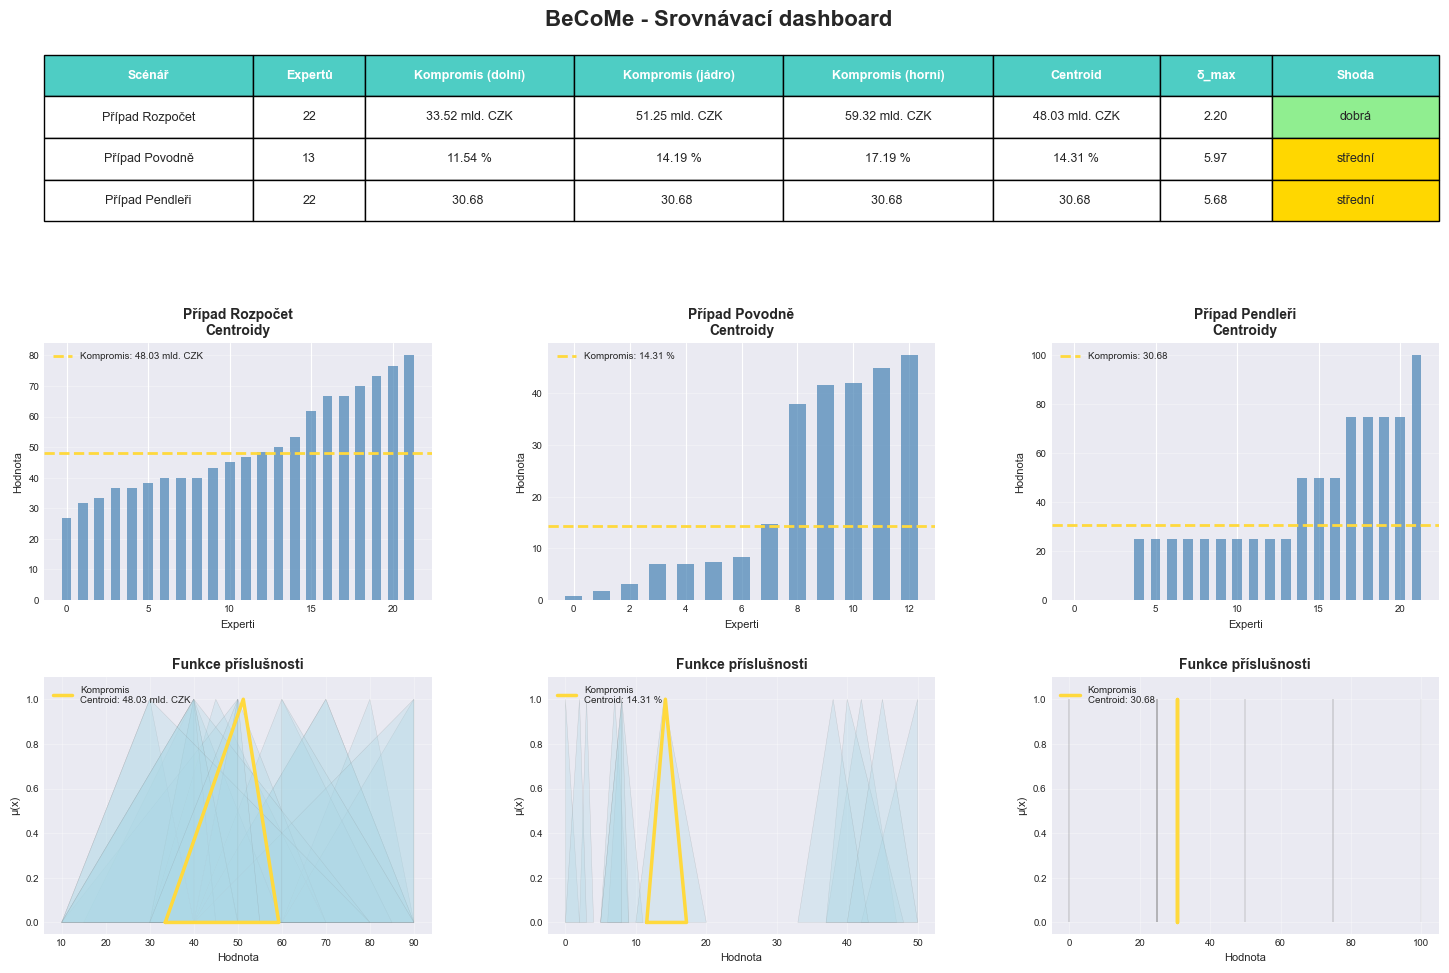

In [9]:
def create_scenario_dashboard():
    """Dashboard pro porovnání všech tří scénářů."""
    # Překlad úrovní shody
    agreement_cs = {"good": "dobrá", "moderate": "střední", "low": "nízká"}

    scenarios = [
        ("Případ Rozpočet", budget_result, len(budget_opinions), "mld. CZK"),
        ("Případ Povodně", floods_result, len(floods_opinions), "%"),
        ("Případ Pendleři", pendlers_result, len(pendlers_opinions), ""),
    ]

    metrics_data = []
    for name, result, num_experts, unit in scenarios:
        agreement = calculate_agreement_level(result.max_error, (5.0, 15.0))
        metrics_data.append(
            {
                "Scénář": name,
                "Expertů": num_experts,
                "Kompromis (dolní)": f"{result.best_compromise.lower_bound:.2f} {unit}",
                "Kompromis (jádro)": f"{result.best_compromise.peak:.2f} {unit}",
                "Kompromis (horní)": f"{result.best_compromise.upper_bound:.2f} {unit}",
                "Centroid": f"{result.best_compromise.centroid:.2f} {unit}",
                "δ_max": f"{result.max_error:.2f}",
                "Shoda": agreement_cs.get(agreement, agreement),
            }
        )

    df_metrics = pd.DataFrame(metrics_data)

    fig = plt.figure(figsize=(18, 12))
    gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)

    fig.suptitle("BeCoMe - Srovnávací dashboard", fontsize=16, fontweight="bold", y=0.88)

    ax_table = fig.add_subplot(gs[0, :])
    ax_table.axis("tight")
    ax_table.axis("off")

    table = ax_table.table(
        cellText=df_metrics.values,
        colLabels=df_metrics.columns,
        cellLoc="center",
        loc="center",
        colWidths=[0.15, 0.08, 0.15, 0.15, 0.15, 0.12, 0.08, 0.12],
    )

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2.5)

    for i in range(len(df_metrics.columns)):
        table[(0, i)].set_facecolor("#4ECDC4")
        table[(0, i)].set_text_props(weight="bold", color="white")

    for i in range(1, len(df_metrics) + 1):
        for j in range(len(df_metrics.columns)):
            if j == len(df_metrics.columns) - 1:
                agreement_level = df_metrics.iloc[i - 1, j]
                if agreement_level == "dobrá":
                    table[(i, j)].set_facecolor("#90EE90")
                elif agreement_level == "střední":
                    table[(i, j)].set_facecolor("#FFD700")
                else:
                    table[(i, j)].set_facecolor("#FFB6C1")

    scenarios_data = [
        (budget_opinions, budget_result, "Případ Rozpočet", 0, "mld. CZK"),
        (floods_opinions, floods_result, "Případ Povodně", 1, "%"),
        (pendlers_opinions, pendlers_result, "Případ Pendleři", 2, ""),
    ]

    for opinions, result, name, col_idx, unit in scenarios_data:
        ax1 = fig.add_subplot(gs[1, col_idx])
        sorted_ops = sorted(opinions, key=lambda x: x.centroid)
        centroids = [op.centroid for op in sorted_ops]

        centroid_value = result.best_compromise.centroid
        label_text = f"Kompromis: {centroid_value:.2f} {unit}".strip()

        ax1.bar(range(len(centroids)), centroids, color="steelblue", alpha=0.7, width=0.6)
        ax1.axhline(
            y=centroid_value, color="#FFD93D", linestyle="--", linewidth=2, label=label_text
        )
        ax1.set_title(f"{name}\nCentroidy", fontsize=10, fontweight="bold")
        ax1.set_xlabel("Experti", fontsize=8)
        ax1.set_ylabel("Hodnota", fontsize=8)
        ax1.tick_params(labelsize=7)
        ax1.grid(True, alpha=0.3, axis="y")
        ax1.legend(fontsize=7, loc="upper left")

        ax2 = fig.add_subplot(gs[2, col_idx])
        for op in opinions:
            x = [
                op.opinion.lower_bound,
                op.opinion.peak,
                op.opinion.upper_bound,
                op.opinion.lower_bound,
            ]
            y = [0, 1, 0, 0]
            ax2.fill(x, y, color="lightblue", alpha=0.3, edgecolor="gray", linewidth=0.3)

        x = [
            result.best_compromise.lower_bound,
            result.best_compromise.peak,
            result.best_compromise.upper_bound,
            result.best_compromise.lower_bound,
        ]
        y = [0, 1, 0, 0]
        compromise_label = (
            f"Kompromis\nCentroid: {result.best_compromise.centroid:.2f} {unit}".strip()
        )
        ax2.plot(x, y, color="#FFD93D", linewidth=2.5, label=compromise_label)

        ax2.set_title("Funkce příslušnosti", fontsize=10, fontweight="bold")
        ax2.set_xlabel("Hodnota", fontsize=8)
        ax2.set_ylabel("μ(x)", fontsize=8)
        ax2.tick_params(labelsize=7)
        ax2.legend(fontsize=7, loc="upper left")
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(-0.05, 1.1)

    plt.savefig(output_dir / "scenario_dashboard.png", dpi=300, bbox_inches="tight")
    plt.show()


create_scenario_dashboard()

### Interpretace

Vizualizace umožňuje rychlé porovnání všech tří případů.
Budget vykazuje nejlepší shodu (zelená), Floods a Pendlers střední (žlutá).

<a id="section-gauge"></a>

## 6. Ukazatel přesnosti

Graf zobrazuje vizuální indikátor kvality shody expertů.
Zelená zóna značí dobrou shodu (δ < 5), žlutá střední (5-15), červená nízkou (> 15).

In [10]:
def plot_accuracy_gauge(result, title, case_name, thresholds=(5.0, 15.0)):
    """Ukazatel přesnosti jako tachometr pro δ_max."""
    delta_max = result.max_error
    agreement = calculate_agreement_level(delta_max, thresholds)

    if agreement == "good":
        color = "#2ECC71"
        gauge_value = 2 / 3 + (1 / 3) * (1 - delta_max / thresholds[0])
        zone = "VÝBORNÁ SHODA"
    elif agreement == "moderate":
        color = "#F39C12"
        normalized = (delta_max - thresholds[0]) / (thresholds[1] - thresholds[0])
        gauge_value = 2 / 3 - (1 / 3) * normalized
        zone = "STŘEDNÍ SHODA"
    else:
        color = "#E74C3C"
        normalized = min((delta_max - thresholds[1]) / thresholds[1], 1.0)
        gauge_value = (1 / 3) * (1 - normalized)
        zone = "NÍZKÁ SHODA"

    fig = plt.figure(figsize=(14, 6))
    gs = GridSpec(1, 2, figure=fig, width_ratios=[1.2, 1])

    ax1 = fig.add_subplot(gs[0])

    zone_ranges = [
        (0, np.pi / 3, "#E74C3C", "Nízká"),
        (np.pi / 3, 2 * np.pi / 3, "#F39C12", "Střední"),
        (2 * np.pi / 3, np.pi, "#2ECC71", "Dobrá"),
    ]

    for start, end, col, _label in zone_ranges:
        theta_zone = np.linspace(start, end, 100)
        x_outer = np.cos(theta_zone)
        y_outer = np.sin(theta_zone)
        x_inner = 0.7 * np.cos(theta_zone)
        y_inner = 0.7 * np.sin(theta_zone)

        vertices = list(zip(x_outer, y_outer, strict=False)) + list(
            zip(x_inner[::-1], y_inner[::-1], strict=False)
        )
        poly = plt.Polygon(vertices, facecolor=col, alpha=0.3, edgecolor=col, linewidth=0)
        ax1.add_patch(poly)

    theta_inner = np.linspace(0, np.pi, 200)
    x_inner_circle = 0.7 * np.cos(theta_inner)
    y_inner_circle = 0.7 * np.sin(theta_inner)
    ax1.fill(
        [*x_inner_circle, x_inner_circle[-1], x_inner_circle[0]],
        [*y_inner_circle, 0, 0],
        color="white",
        zorder=2,
    )

    angle = np.pi * gauge_value
    arrow_length = 0.85
    ax1.arrow(
        0,
        0,
        arrow_length * np.cos(angle),
        arrow_length * np.sin(angle),
        head_width=0.1,
        head_length=0.1,
        fc=color,
        ec=color,
        linewidth=3,
        zorder=5,
    )

    circle = plt.Circle((0, 0), 0.15, color="black", zorder=10)
    ax1.add_patch(circle)

    ax1.text(
        0,
        -0.3,
        f"δ_max = {delta_max:.2f}",
        ha="center",
        va="top",
        fontsize=18,
        fontweight="bold",
        color="black",
    )
    ax1.text(0, -0.45, zone, ha="center", va="top", fontsize=12, fontweight="bold", color="black")

    ax1.text(
        -0.85, 0.5, "Dobrá\n(< 5.0)", ha="center", fontsize=9, color="black", fontweight="bold"
    )
    ax1.text(
        0, 1.05, "Střední\n(5.0-15.0)", ha="center", fontsize=9, color="black", fontweight="bold"
    )
    ax1.text(
        0.85, 0.5, "Nízká\n(> 15.0)", ha="center", fontsize=9, color="black", fontweight="bold"
    )

    ax1.set_xlim(-1.2, 1.2)
    ax1.set_ylim(-0.6, 1.3)
    ax1.set_aspect("equal")
    ax1.axis("off")
    ax1.set_title(
        f"{title}\nUkazatel kvality shody expertů", fontsize=12, fontweight="bold", pad=20
    )

    ax2 = fig.add_subplot(gs[1])

    ax2.barh(["δ_max"], [delta_max], color=color, height=0.5, edgecolor="black", linewidth=2)

    ax2.axvline(
        x=thresholds[0],
        color="#2ECC71",
        linestyle="--",
        linewidth=2,
        label="Dobrá shoda (δ_max < 5.0)",
    )
    ax2.axvline(
        x=thresholds[1],
        color="#E74C3C",
        linestyle="--",
        linewidth=2,
        label="Nízká shoda (δ_max > 15.0)",
    )

    ax2.axvspan(0, thresholds[0], alpha=0.2, color="#2ECC71")
    ax2.axvspan(thresholds[0], thresholds[1], alpha=0.2, color="#F39C12")
    ax2.axvspan(
        thresholds[1], max(delta_max * 1.2, thresholds[1] * 1.2), alpha=0.2, color="#E74C3C"
    )

    ax2.set_xlabel("Hodnota δ_max", fontsize=11, fontweight="bold")
    ax2.set_title("δ_max vzhledem k prahům", fontsize=12, fontweight="bold")
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3, axis="x")
    ax2.set_xlim(0, max(delta_max * 1.2, thresholds[1] * 1.2))

    ax2.text(
        delta_max + 0.5,
        0,
        f"{delta_max:.2f}",
        va="center",
        fontsize=12,
        fontweight="bold",
        color="black",
    )

    plt.tight_layout()
    plt.savefig(output_dir / f"{case_name}_accuracy_gauge.png", dpi=300, bbox_inches="tight")
    plt.show()

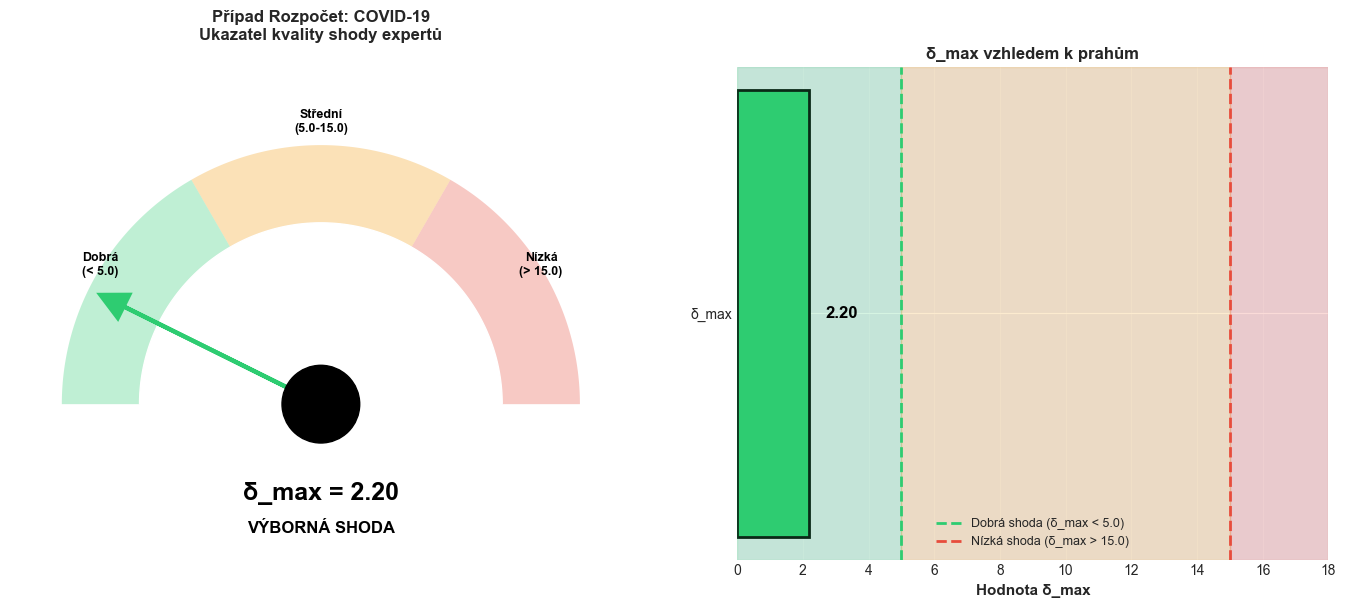

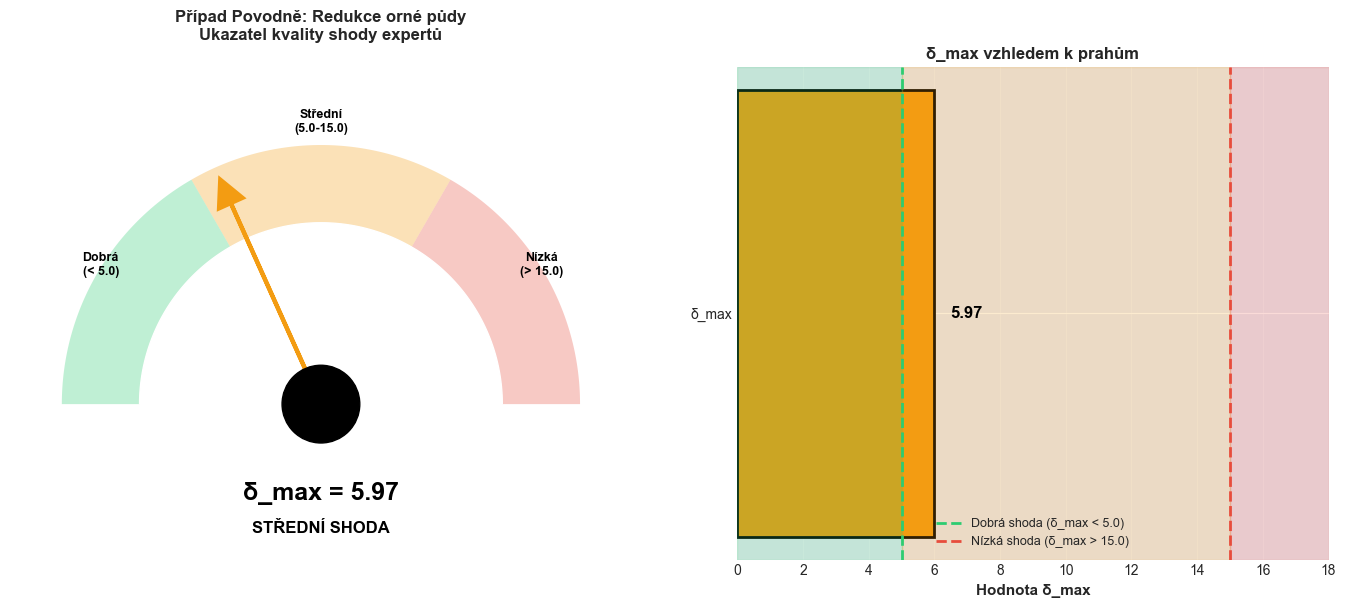

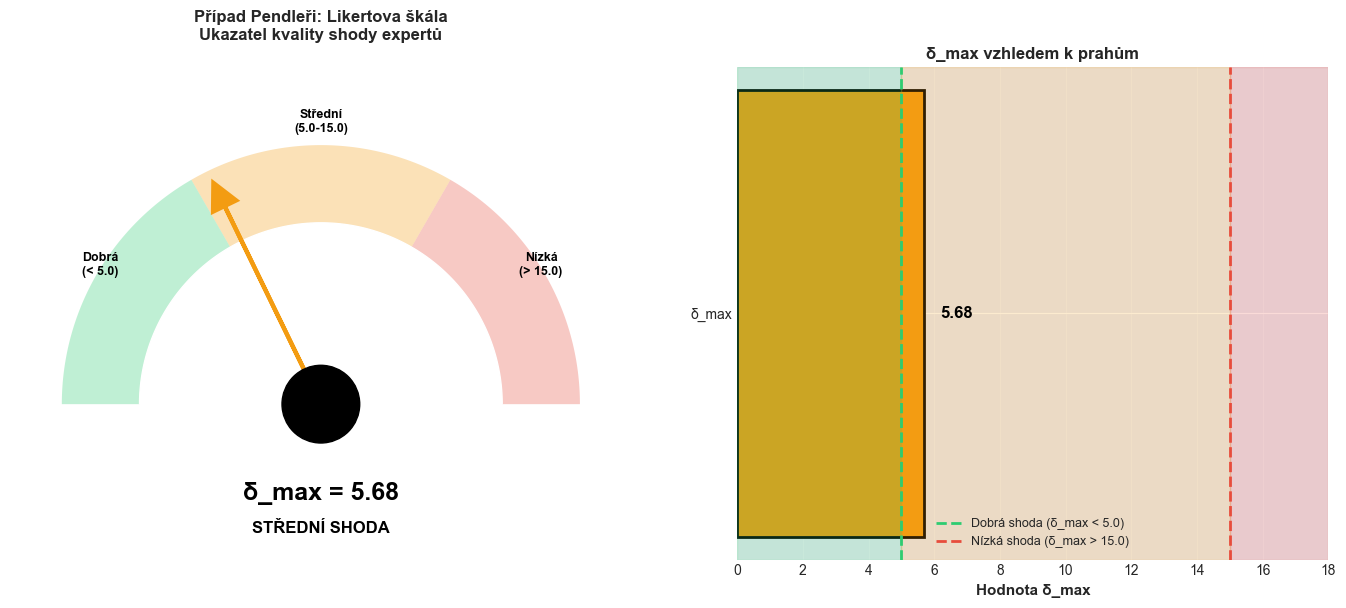

In [11]:
plot_accuracy_gauge(budget_result, "Případ Rozpočet: COVID-19", "budget")
plot_accuracy_gauge(floods_result, "Případ Povodně: Redukce orné půdy", "floods")
plot_accuracy_gauge(pendlers_result, "Případ Pendleři: Likertova škála", "pendlers")

### Interpretace

**Budget:** Šipka ukazuje do zelené zóny (δ_max = 2.20). Shoda je výborná.

**Floods:** Šipka se nachází na hranici žluté zóny (δ_max = 5.97). Shoda je střední kvůli polarizaci.

**Pendlers:** Šipka ukazuje do žluté zóny (δ_max = 5.68). Shoda je střední kvůli outlierovi.

<a id="section-conclusion"></a>

## 7. Závěr

### Přehled výsledků

| Případ | Expertů | δ_max | Hodnocení |
|--------|---------|-------|------------|
| Budget | 22 | 2.20 | Dobrá shoda |
| Floods | 13 | 5.97 | Bimodální rozdělení |
| Pendlers | 22 | 5.68 | Silný outlier |

Metoda BeCoMe úspěšně agregovala expertní odhady ve všech případech.
Nejvyšší kvalitu vykazuje Budget (nízká δ_max), nejsložitější situace nastala u Floods (polarizace názorů).